<a href="https://colab.research.google.com/github/9berny9/bikes/blob/main/bikes_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [167]:
import pandas as pd
import numpy as np

In [168]:
!git clone https://github.com/9berny9/bikes

fatal: destination path 'bikes' already exists and is not an empty directory.


# BIKES IN EDINBURGH
1. [Zadání](#1)
2. [Úprava dat](#2)
3. [Analýza](#3)



## Zadání <a name="1"></a>



V Edinburghu, stejně jako v dalších městech, funguje systém "bike sharing" - ve městě jsou stanice s koly, člověk si může nějaké půjčit a potom ho vrátit v nějaké další stanici. Problém je, že v některých stanicích se kola pravidelně hromadí a jinde naopak chybí. Provozovatel kol, firma Just Eat Cycles, zadala projekt, jehož cílem je systém zefektivnit.

Coby datový analytik jste součástí týmu, který na projektu pracuje. Vaším úkolem je zpracovat relevantní data a zjistit z nich informace užitečné pro zbytek týmu. Máte k dispozici data o všech výpůjčkách (na ENGETO databázi v tabulce edinburgh_bikes). Proveďte standardní deskriptivní statistiku dat. Také zjistěte minimálně následující informace:

identifikujte aktivní a neaktivní stanice
identifikujte nejfrekventovanější stanice
identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí
spočítejte vzdálenosti mezi jednotlivými stanicemi
jak dlouho trvá jedna výpůjčka? Najděte odlehlé hodnoty, zobrazte histogram
Analýza poptávky:

zobrazte vývoj poptávky po půjčování kol v čase
identifikujte příčiny výkyvů poptávky
zjistěte vliv počasí na poptávku po kolech (údaje o počasí v Edinburghu jsou v tabulce edinburgh_weather)
půjčují si lidé kola více o víkendu než během pracovního týdne?
Výstupem analýzy bude ideálně jupyter notebook nebo colab notebook uložený na Vašem githubu. Výstupy Vaší analýzy musí být zřejmé i bez spouštění kódu. V textových buňkách popište, jak jste postupovali a napište své závěry. Pokud v zadání chybí nějaká informace, doplňte ji podle vlastního uvážení, své rozhodnutí uveďte a vysvětlete v notebooku.

## Úprava dat <a name="2"></a>

* Veškerá práce s databází a úprava datových formátů se nachází v repozitáři zde: https://github.com/9berny9/bikes/blob/90970fb641920d89a08362277943fd1b273625eb/data_process.ipynb

* Výstupem úpravy dat jsou pickle soubory uložené v repozitáři **bikes/Database/modified_data**, na kterých probíhá celá analýza.

## Načtení Datasetů<a name="3.1"></a>

In [376]:
# Dataframe všech stanic s informacemi o nich
url_stations = "/content/bikes/Database/modified_data/stations.pkl"
df_s = pd.read_pickle(url_stations)
# Dataframe všech záznamů o zapůjčení a vrácení kol
url_bikes = "/content/bikes/Database/modified_data/bikes.pkl"
df_b = pd.read_pickle(url_bikes)
# Sjednocený dataframe záznamů o vypůjčení a počasí.
url_merged = "/content/bikes/Database/modified_data/merged.pkl"
df_m = pd.read_pickle(url_merged)

## Proměnné<a name="3.2"></a>

Pro analýzu využívám proměnné, které si definuji níže.

In [220]:
# rozsah dní datasetu bikes
date_first = df_b.start.dt.date.min()
date_last = df_b.start.dt.date.max()
date_range = (date_last - date_first).days
print(f"Rozsah dní datasetu: {date_range} dní")

Rozsah dní datasetu: 1019 dní


## Analýza<a name="3"></a>

### Stanice<a name="3.3"></a>

#### Deskriptivní statistika<a name="3.1.1"></a>

In [170]:
# deskriptivní statistika
df_s[["start_frequency", "end_frequency"]].describe()

,start_frequency,end_frequency
count,200.00000,200.00000
mean,2191.29500,2191.29500
std,2878.05144,2895.77673
min,0.00000,0.00000
25%,240.75000,232.25000
50%,1044.00000,1223.50000
75%,3119.50000,2878.50000
max,17390.00000,16656.00000


*   Průměrný počet půjčených kol na stanici je **2213 výpujček kol**, což je **2,17** výpujček za den.
*   Medián počtu půjčených kol na stanici je **1064 výpujček kol**, což je **1,04** výpujček za den.
*   Průměrný počet vrácených kola na stanici je **2202 vrácení kol**, což je **2,16** výpujček za den.
*   Medián počtu vrácených kol na stanici je **1231 vrácení kol**, což je **1,21** výpujček za den.
*   Minimální hodnota počtu výpujček ve stanicích je **0** a počtu vrácení je **0** za celé období.   Tyto stanice můžeme označit jako neaktivní a budou řešeny v pozdější analýze).
*   Maximální hodnota počtu výpujček je **17390**, což je **17,07** výpujček za den a maximální hodnota počtu vratek je **16656**, což je **16,35** vratek za den.


V Edinburghu se nachází **200** stanic pro půjčení kol a data jsou sbírány od **2018-09-15** do **2021-06-30**, což je **1019** dní.

In [171]:
# zobrazení grafů přímo v notebooku
%matplotlib inline
# import knihovny
from matplotlib import pyplot as plt

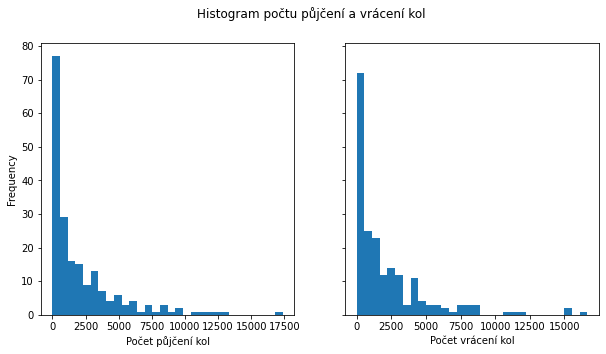

In [172]:
# histogram počtu půjčení a vrácení kol
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)  # Jeden řádek, dva sloupce, první graf
ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)  # Druhý graf, sdílená osa Y
df_s.start_frequency.plot.hist(ax=ax1, bins=30);
df_s.end_frequency.plot.hist(ax=ax2, bins=30);
fig.suptitle("Histogram počtu půjčení a vrácení kol");
ax1.set_xlabel("Počet půjčení kol");
ax2.set_xlabel("Počet vrácení kol");


Z histogramu můžeme vidět, že se nejedná o normální rozdělení pravděpodobnosti, ale šikmé rozdělení, takže v datech se vyskytují odlehlé hodnoty.

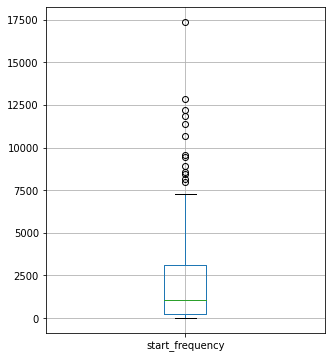

In [173]:
#  inter-quartile range
df_s.boxplot(column="start_frequency", figsize=(5, 6));

Z boxplotu lze vidět, že hodnoty přibližně nad 7500 jsou odlehlé -> výpočet níže.

In [174]:
# Metoda IQR - interquartal range 
Q1_s = df_s.start_frequency.quantile(0.25)
Q3_s = df_s.start_frequency.quantile(0.75)
IQR_s = Q3_s - Q1_s

Q1_e = df_s.end_frequency.quantile(0.25)
Q3_e = df_s.end_frequency.quantile(0.75)
IQR_e = Q3_e - Q1_e

# zobrazení
print("Q1 pro vypůjčení: ", Q1_s)
print("Q3 pro vypůjčení: ", Q3_s)
print("IQR pro vypůjčení: ", IQR_s)
print('')
print("Q1 pro vrácení: ", Q1_e)
print("Q3 pro vrácení: ", Q3_e)
print("IQR pro vrácení: ", IQR_e)

Q1 pro vypůjčení:  240.75
Q3 pro vypůjčení:  3119.5
IQR pro vypůjčení:  2878.75

Q1 pro vrácení:  232.25
Q3 pro vrácení:  2878.5
IQR pro vrácení:  2646.25


In [175]:
# bounders
weak_outlier_s = Q3_s + 1.5 * IQR_s
strong_outlier_s = Q3_s + 3 * IQR_s

weak_outlier_e = Q3_e + 1.5 * IQR_e
strong_outlier_e = Q3_e + 3 * IQR_e

# df outlier
df_s_weak = df_s["start_frequency"][df_s["start_frequency"] > weak_outlier_s].count()
df_s_strong = df_s["start_frequency"][df_s["start_frequency"] > strong_outlier_s].count()

df_e_weak = df_s["end_frequency"][df_s["end_frequency"] > weak_outlier_e].count()
df_e_strong = df_s["end_frequency"][df_s["end_frequency"] > strong_outlier_e].count()

# zobrazení
print(f"Hranice slabé odlehlé hodnoty vypůjčení kol je: {weak_outlier_s} a počet stanic: {df_s_weak}")
print(f"Hranice silné odlehlé hodnoty vypůjčení kol je: {strong_outlier_s} a počet stanic: {df_s_strong}")
print("")
print(f"Hranice slabé odlehlé hodnoty vrácení kol je: {weak_outlier_e} a počet stanic: {df_e_weak}")
print(f"Hranice silné odlehlé hodnoty vrácení kol je: {strong_outlier_e} a počet stanic: {df_e_strong}")

Hranice slabé odlehlé hodnoty vypůjčení kol je: 7437.625 a počet stanic: 13
Hranice silné odlehlé hodnoty vypůjčení kol je: 11755.75 a počet stanic: 4

Hranice slabé odlehlé hodnoty vrácení kol je: 6847.875 a počet stanic: 16
Hranice silné odlehlé hodnoty vrácení kol je: 10817.25 a počet stanic: 6


Další metoda určení odlehlých hodnot může být Z score.

**Z score**   
je metoda detekce odlehlých měření definovaná jednoduchým vzorcem a závislá na směrodatné odchylce. Právě díky jednoduchému vzorečku a nastavitelné hranici je možné si určit, co pro nás znamená odlehlé měření.   
Vzorec vypadá následovně: $$ z = \frac{x - \mu}{\sigma} $$

In [176]:
# filtrace dat pro hodnoty vetsi jak smerodatna odchylka
std = 3
zs = abs((df_s.start_frequency - df_s.start_frequency.mean()) / df_s.start_frequency.std())
df_s.start_frequency[zs > std]

1      12218.0
9      17390.0
16     12846.0
98     11373.0
137    11843.0
Name: start_frequency, dtype: float64

#### Mapa stanic<a name="3.1.1"></a>

In [177]:
import plotly.express as px

In [178]:
# vykreslení mapy stanic
fig = px.scatter_mapbox(df_s,lat="lat", lon="lon", hover_name = "name", hover_data = ["description","start_frequency","end_frequency"] ,zoom=10, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Vzdálenosti stanic<a name="3.1.2"></a>

In [179]:
from sklearn.metrics import DistanceMetric

In [180]:
# kopie dataframu pro výpočet vzdáleností seřazená podle id
df_s2 = df_s.copy().sort_values(by="id")

postup výpočtu vzdáleností:   
https://medium.com/@danalindquist/finding-the-distance-between-two-lists-of-geographic-coordinates-9ace7e43bb2f

In [181]:
# převedení na radiány
df_s2['lat'] = np.radians(df_s2['lat'])
df_s2['lon'] = np.radians(df_s2['lon'])

In [182]:
# vytvoření matice pomocí knihovny
dist = DistanceMetric.get_metric('haversine')

In [183]:
# radius země v km
earth_radius = 6373
# matice s výpočtem vzdálenosti mezi stanicemi v km
distance = pd.DataFrame(dist.pairwise(
    (df_s2[['lat','lon']]) * earth_radius).round(2),
      columns=df_s2.id, index=df_s2.id)

In [184]:
distance.head()

id,171,183,189,225,241,242,246,247,248,249,...,1868,1869,1870,1871,1874,1877,2259,2263,2265,2268
id,,,,,,,,,,,,,,,,,,,,,
171,0.00,0.96,0.80,1.03,1.84,1.84,0.64,1.92,0.33,1.15,...,1.07,0.89,0.23,1.09,1.30,0.70,2.47,0.58,1.05,1.51
183,0.96,0.00,0.19,0.81,1.13,1.13,1.59,1.75,0.66,1.78,...,1.58,1.60,1.18,0.57,1.36,1.59,1.51,1.37,1.95,0.80
189,0.80,0.19,0.00,0.70,1.18,1.18,1.44,1.88,0.48,1.74,...,1.56,1.53,1.02,0.69,1.43,1.46,1.67,1.18,1.76,0.83
225,1.03,0.81,0.70,0.00,0.83,0.83,1.51,2.54,0.79,2.18,...,2.09,1.92,1.22,1.37,2.11,1.69,1.65,0.97,1.47,0.58
241,1.84,1.13,1.18,0.83,0.00,0.00,2.33,2.10,1.54,2.91,...,2.69,2.70,2.04,1.54,2.28,2.52,0.85,1.76,2.08,0.35


#### Aktivní a neaktivní stanice<a name="3.1.2"></a>


Z posbíraných dat jsme zjistili, že se průměrně půčují 2,2 kola denně na každé stanici. Pro určení aktivních stanic jsme si určili, že za aktivní stanice budeme považovat pouze stanice, na kterých proběhne v průměru minimálně **0,3** výpujček kol denně.

In [229]:
# pocet vypujceni prepoctenych na 0,3 denně
rent_by_day = 0.3
days_variable = rent_by_day * date_range
# vsechny stanice, které mají v průměru méně jak 0,3 výpujček kol za den
active_stations = df_s[df_s["start_frequency"] > days_variable]
inactive_stations = df_s[df_s["start_frequency"] < days_variable]


In [231]:
print(f"Počet aktivních stanic je: {active_stations.id.count()} stanic")
print(f"Počet neaktivních stanic je: {inactive_stations.id.count()} stanic")

Počet aktivních stanic je: 145 stanic
Počet neaktivních stanic je: 55 stanic


#### Nejfrekventovanější stanice<a name="3.1.2"></a>

In [249]:
# 10 nejfrekventovanějších stanic pro vypůjčení kola
top_rent_stations = active_stations.sort_values(by= "start_frequency", ascending= False).head(10).reset_index()

In [250]:
top_rent_stations

,index,id,name,description,lat,lon,start_frequency,end_frequency
0,9,265,Meadows East,Melville Terrace,55.939809,-3.182739,17390.0,15225.0
1,16,248,Bristo Square,"Bristo Square, near Potter Row",55.946004,-3.188665,12846.0,7898.0
2,1,259,St Andrew Square,North East corner,55.954749,-3.192774,12218.0,8372.0
3,137,1728,Portobello - Kings Road,Foot of Kings Road next to the promenade,55.957915,-3.118332,11843.0,16656.0
4,98,1024,Meadow Place 2,,55.940238,-3.194640,11373.0,8792.0
5,17,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,10662.0,15254.0
6,2,262,Canonmills,near Tesco's,55.962804,-3.196284,9551.0,11940.0
7,7,264,Pollock Halls,Pollock Halls Entrance,55.939963,-3.171586,9441.0,6628.0
8,31,289,Castle Street,Near Rose Street,55.951501,-3.203184,8923.0,7398.0
9,10,183,Waverley Bridge,near the top of the South ramp,55.951344,-3.191421,8569.0,8402.0


In [246]:
# 10 nejfrekventovanějších stanic pro vypůjčení kola
top_return_stations = active_stations.sort_values(by= "end_frequency", ascending= False).head(10).reset_index()

In [247]:
top_return_stations

,index,id,name,description,lat,lon,start_frequency,end_frequency
0,137,1728,Portobello - Kings Road,Foot of Kings Road next to the promenade,55.957915,-3.118332,11843.0,16656.0
1,17,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,10662.0,15254.0
2,9,265,Meadows East,Melville Terrace,55.939809,-3.182739,17390.0,15225.0
3,2,262,Canonmills,near Tesco's,55.962804,-3.196284,9551.0,11940.0
4,180,1824,Duke Street,Junction with Easter Road,55.969012,-3.167395,7288.0,11264.0
5,44,358,Leith Walk,Leith Walk opposite Dalmeny Street,55.965040,-3.176686,7964.0,11052.0
6,98,1024,Meadow Place 2,,55.940238,-3.194640,11373.0,8792.0
7,10,183,Waverley Bridge,near the top of the South ramp,55.951344,-3.191421,8569.0,8402.0
8,1,259,St Andrew Square,North East corner,55.954749,-3.192774,12218.0,8372.0
9,22,258,Stockbridge,Hamilton Place by Dean Bank Lane,55.958566,-3.208070,6219.0,8212.0


#### Dostupnost kol na stanicích<a name="3.1.2"></a>

Pro výpočet hromadění a nedostatku kol na stanicích si definujeme, že nás zajímají pouze stanice, kterým chybí nebo je přebytek kol průměrně větší jak **3 kola na den.**

In [319]:
# proměnná počet kol za den
rent_diff = 3

In [321]:
df_s_new = df_s.copy()

In [322]:
# výpočet rozdílu mezi počtem vypůjčení a vrácení kol přepočítaných na den
df_s_new["bikes_on_stations"] = (df_s_new["start_frequency"] - df_s_new["end_frequency"]) / date_range

In [323]:
df_s_new

,id,name,description,lat,lon,start_frequency,end_frequency,bikes_on_stations
0,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,8134.0,4980.0,3.095191
1,259,St Andrew Square,North East corner,55.954749,-3.192774,12218.0,8372.0,3.774289
2,262,Canonmills,near Tesco's,55.962804,-3.196284,9551.0,11940.0,-2.344455
3,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254.0,196.0,0.056919
4,253,Kings Building 2,Sanderson Building,55.923202,-3.171646,4096.0,4557.0,-0.452404
...,...,...,...,...,...,...,...,...
195,2263,Musselburgh Lidl,Musselborough North High Street opposite Harbo...,55.943880,-3.066754,709.0,838.0,-0.126595
196,2265,Musselburgh Brunton Hall,Adjacent to the Brunton Theatre,55.944009,-3.058493,294.0,379.0,-0.083415
197,2268,Picady Place,Outside Omni Centre,55.956535,-3.186248,1929.0,1475.0,0.445535
198,242,Virtual Depot,Virtual Depot,55.972402,-3.155794,0.0,2.0,-0.001963


In [330]:
# nedostatek kol
not_enough = df_s_new[df_s_new["bikes_on_stations"] >= rent_diff].sort_values(by="bikes_on_stations")

In [332]:
# hromadění kol
too_much = df_s_new[df_s_new["bikes_on_stations"] <= (- rent_diff)].sort_values(by="bikes_on_stations")

In [333]:
too_much

,id,name,description,lat,lon,start_frequency,end_frequency,bikes_on_stations
137,1728,Portobello - Kings Road,Foot of Kings Road next to the promenade,55.957915,-3.118332,11843.0,16656.0,-4.723258
17,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116,10662.0,15254.0,-4.506379
180,1824,Duke Street,Junction with Easter Road,55.969012,-3.167395,7288.0,11264.0,-3.901865
44,358,Leith Walk,Leith Walk opposite Dalmeny Street,55.965040,-3.176686,7964.0,11052.0,-3.030422


In [334]:
not_enough

,id,name,description,lat,lon,start_frequency,end_frequency,bikes_on_stations
11,189,City Chambers,City Chambers Quadrangle,55.950109,-3.190258,5836.0,2723.0,3.054956
0,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,8134.0,4980.0,3.095191
1,259,St Andrew Square,North East corner,55.954749,-3.192774,12218.0,8372.0,3.774289
16,248,Bristo Square,"Bristo Square, near Potter Row",55.946004,-3.188665,12846.0,7898.0,4.855741


*   Na **4 stanicích** je průměrně nedostatek kol.
*   Na **4 stanicích** je průměrně přebytek kol.

Pro stanice s přebytkem kol je potřeba zajistit přepravu do nejbližší stanice, která má nedostatek kol a naopak.

### Záznamy o zapůjčení<a name="3.1.2"></a>

#### Deskriptivní statistika<a name="3.1.2"></a>

In [381]:
df_b["duration"].describe()

count                       438259
mean     0 days 00:32:28.838038694
std      0 days 01:34:17.134780300
min                0 days 00:01:01
25%                0 days 00:10:24
50%                0 days 00:19:23
75%                0 days 00:42:09
max               27 days 08:29:08
Name: duration, dtype: object

In [382]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438259 entries, 0 to 438258
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   start              438259 non-null  datetime64[ns] 
 1   end                438259 non-null  datetime64[ns] 
 2   duration           438259 non-null  timedelta64[ns]
 3   start_id           438259 non-null  int64          
 4   start_name         438259 non-null  object         
 5   start_description  435549 non-null  object         
 6   start_latitude     438259 non-null  float64        
 7   start_longitude    438259 non-null  float64        
 8   end_id             438259 non-null  int64          
 9   end_name           438259 non-null  object         
 10  end_description    435256 non-null  object         
 11  end_latitude       438259 non-null  float64        
 12  end_longitude      438259 non-null  float64        
dtypes: datetime64[ns](2), float64